In [1]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate

J(GND) = 0.308714460651
J(SRC) = 0.307868173601
V(A) = 0.332751988385
V(B) = 0.555767265133
ΔV(A-B) = -0.223015276748
J(GND)/ΔV = -1.38427494812
1.4


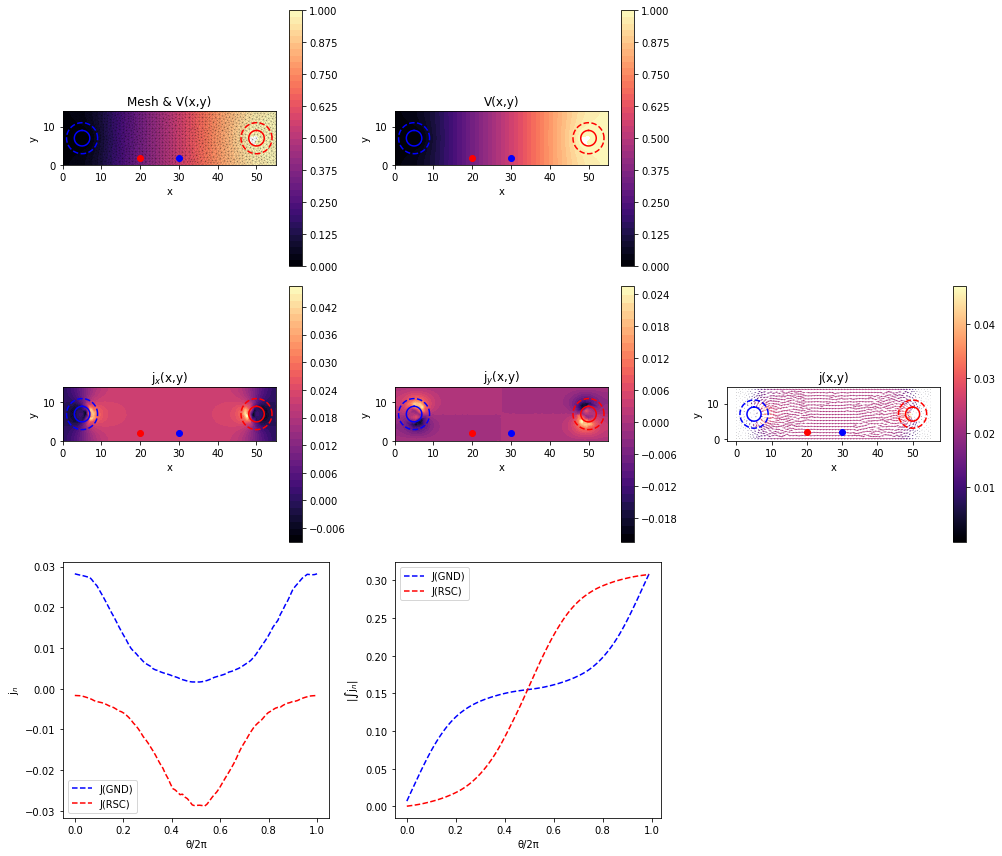

In [43]:
#SU8STO2
L=55;W=14;
xGND=5;yGND=7;
xSRC=50;ySRC=7;
xA=20;yA=2;
xB=20+10;yB=2;
V=run_solver(40,2, xGND,yGND,xSRC,ySRC,xA,yA,xB,yB,L,W) #args:meshsize,r,xGND,yGND,xSRC,ySRC,xA,yA,xB,yB,L,W
print(W/10)

J(GND) = 0.430331414742
J(SRC) = 0.428122954046
V(A) = 0.261678931683
V(B) = 0.54793135058
ΔV(A-B) = -0.286252418898
J(GND)/ΔV = -1.5033284833
1.5


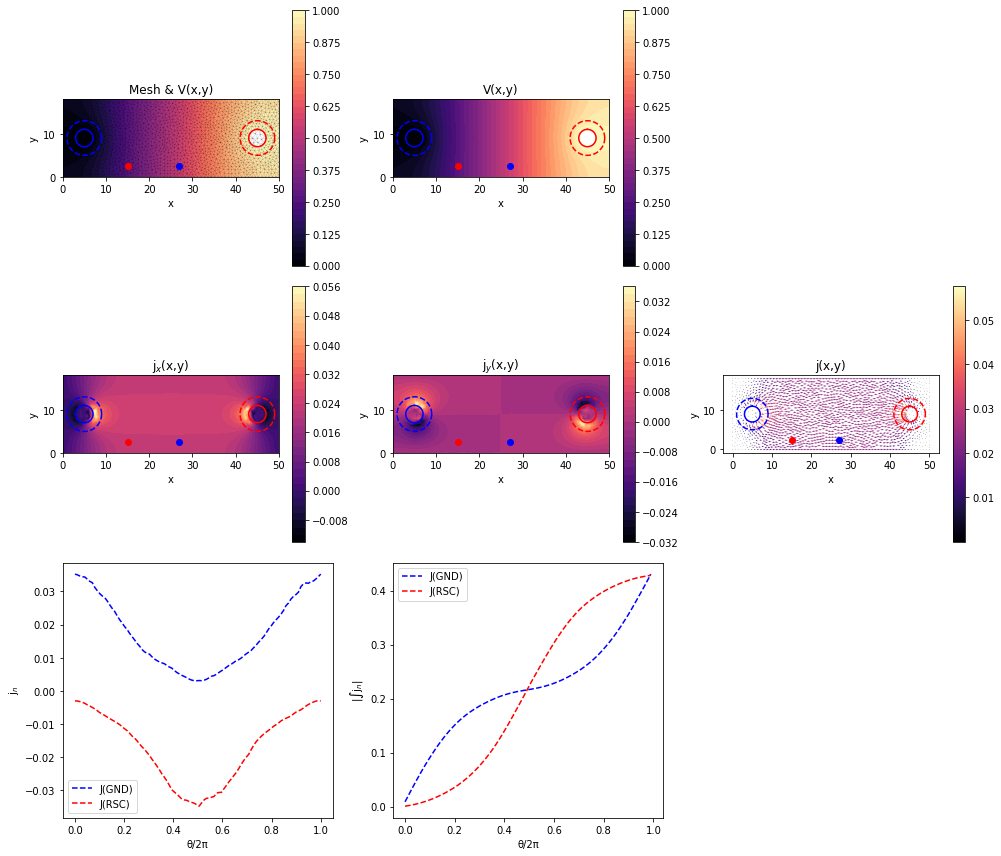

In [44]:
#SU8STO42L2
L=50;W=18;
xGND=5;yGND=9;
xSRC=45;ySRC=9;
xA=15;yA=2.5;
xB=15+12;yB=2.5;
V=run_solver(40,2, xGND,yGND,xSRC,ySRC,xA,yA,xB,yB,L,W) #args:meshsize,r,xGND,yGND,xSRC,ySRC,xA,yA,xB,yB,L,W
print(W/12)

In [30]:
def solver(meshsize,r,xGND,yGND,xSRC,ySRC,L,W):
    degree=2
    #geometry setup
    cen=[2.5,2.5]; 
    
    domain = Rectangle(Point(0, 0),Point(L, W))
    circ2 = Circle(Point(xGND,yGND), r)
    domain.set_subdomain(2, circ2)
    circ3 = Circle(Point(xSRC,ySRC), r)
    domain.set_subdomain(3, circ3)

    
    mesh = generate_mesh(domain, meshsize)   
    V = FunctionSpace(mesh, 'P', degree)

    def boundary(x, on_boundary):
        return on_boundary

    boundary_markers = MeshFunction('size_t', mesh, 2, mesh.domains())
    boundaries = MeshFunction('size_t', mesh, 1, mesh.domains())
    for f in facets(mesh):
        domains = []
        for c in cells(f):
            domains.append(boundary_markers[c])
        domains = list(set(domains))
        if len(domains) > 1:     
            boundaries[f]=np.max(domains)

    pad_bc2 = DirichletBC(V, Constant(0), boundaries, 2)
    pad_bc3 = DirichletBC(V, Constant(1), boundaries, 3)
    boundary_bc = DirichletBC(V, Constant(0), boundary)
    bc = [pad_bc2, pad_bc3]

    #variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    a = dot(grad(u), grad(v))*dx
    g = Constant('0')
    L = Constant('0') * v * dx - g*v*ds
        
    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    return u

def run_solver(meshsize,r,xGND,yGND,xSRC,ySRC,xA,yA,xB,yB,L,W):
    V = solver(meshsize,r,xGND,yGND,xSRC,ySRC,L,W)
    cen=[2.5,2.5];#clock center
    Npts=100; #number of points for 1D current interpolation path
    fr=2; # multiplication factor for radius of 1D current interpolation path
    padGND=[xGND,yGND];
    padSRC=[xSRC,ySRC];
    padA=[xA,yA];
    padB=[xB,yB];
    θ = np.linspace(0,2*np.pi,Npts); # θ = angle for the radial 1d current interpolation path
    xGND = np.array([padGND[0]+fr*r*np.cos(θ),padGND[1]+fr*r*np.sin(θ)])
    xSRC = np.array([padSRC[0]+fr*r*np.cos(θ),padSRC[1]+fr*r*np.sin(θ)])
    nGND = np.array([np.cos(θ),np.sin(θ)])
    
    plt.figure(figsize=[14,12])
    plt.subplot(3,3,1)
    plot(V.function_space().mesh(),color='k',linewidth=0.1)
    p=plot(V,cmap='magma');plt.colorbar(p);
    plt.title('Mesh & V(x,y)');plt.xlabel('x');plt.ylabel('y')
    plt.plot(xGND[0,:],xGND[1,:],'b--');plt.plot(padGND[0]+r*np.sin(θ),padGND[1]+r*np.cos(θ),'b-')
    plt.plot(xSRC[0,:],xSRC[1,:],'r--');plt.plot(padSRC[0]+r*np.sin(θ),padSRC[1]+r*np.cos(θ),'r-')
    plt.plot(padA[0],padA[1],'ro');plt.plot(padB[0],padB[1],'bo');

    
    plt.subplot(3,3,2)
    p=plot(V,cmap='magma');plt.colorbar(p)
    plt.title('V(x,y)');plt.xlabel('x');plt.ylabel('y')
    plt.plot(xGND[0,:],xGND[1,:],'b--');plt.plot(padGND[0]+r*np.sin(θ),padGND[1]+r*np.cos(θ),'b-')
    plt.plot(xSRC[0,:],xSRC[1,:],'r--');plt.plot(padSRC[0]+r*np.sin(θ),padSRC[1]+r*np.cos(θ),'r-')
    plt.plot(padA[0],padA[1],'ro');plt.plot(padB[0],padB[1],'bo');
    plt.tight_layout()
        

    
    plt.subplot(3,3,4);jx=project(V.dx(0))
    p=plot(jx,cmap='magma');plt.colorbar(p);
    plt.title('j$_x$(x,y)');plt.xlabel('x');plt.ylabel('y')
    plt.plot(xGND[0,:],xGND[1,:],'b--');plt.plot(padGND[0]+r*np.sin(θ),padGND[1]+r*np.cos(θ),'b-')
    plt.plot(xSRC[0,:],xSRC[1,:],'r--');plt.plot(padSRC[0]+r*np.sin(θ),padSRC[1]+r*np.cos(θ),'r-')
    plt.plot(padA[0],padA[1],'ro');plt.plot(padB[0],padB[1],'bo');

    plt.subplot(3,3,5);jy=project(V.dx(1))
    p=plot(jy,cmap='magma');plt.colorbar(p);
    plt.title('j$_y$(x,y)');plt.xlabel('x');plt.ylabel('y')
    plt.plot(xGND[0,:],xGND[1,:],'b--');plt.plot(padGND[0]+r*np.sin(θ),padGND[1]+r*np.cos(θ),'b-')
    plt.plot(xSRC[0,:],xSRC[1,:],'r--');plt.plot(padSRC[0]+r*np.sin(θ),padSRC[1]+r*np.cos(θ),'r-')
    plt.plot(padA[0],padA[1],'ro');plt.plot(padB[0],padB[1],'bo');

    plt.subplot(3,3,6);p=plot((grad(V)),cmap='magma');plt.colorbar(p);
    plt.title('j(x,y)');plt.xlabel('x');plt.ylabel('y')
    plt.plot(xGND[0,:],xGND[1,:],'b--');plt.plot(padGND[0]+r*np.sin(θ),padGND[1]+r*np.cos(θ),'b-')
    plt.plot(xSRC[0,:],xSRC[1,:],'r--');plt.plot(padSRC[0]+r*np.sin(θ),padSRC[1]+r*np.cos(θ),'r-')
    plt.plot(padA[0],padA[1],'ro');plt.plot(padB[0],padB[1],'bo');
    
    plt.subplot(3,3,7)
    JGND = [np.dot(nGND[:,ii],[jx(xGND[:,ii]),jy(xGND[:,ii])]) for ii in range(0,Npts)]
    plt.plot(θ/2/np.pi,JGND,'b--');
    JSRC = [np.dot(nGND[:,ii],[jx(xSRC[:,ii]),jy(xSRC[:,ii])]) for ii in range(0,Npts)]
    plt.plot(θ/2/np.pi,JSRC,'r--');
    plt.xlabel('θ/2π');plt.ylabel('j$_n$');plt.legend(['J(GND)','J(RSC)'])
    
    plt.subplot(3,3,8)
    JnGND=np.abs(scipy.integrate.cumtrapz(JGND,θ*fr*r))
    plt.plot(θ[0:-1]/2/np.pi,JnGND,'b--');
    JnSRC=np.abs(scipy.integrate.cumtrapz(JSRC,θ*fr*r))
    plt.plot(θ[0:-1]/2/np.pi,JnSRC,'r--');
    plt.xlabel('θ/2π');plt.ylabel(r'|$\int$j$_n$|');plt.legend(['J(GND)','J(RSC)'])

    plt.tight_layout()
    IntJnGND=np.abs(np.max(JnGND)); IntJnSRC=np.abs(np.max(JnSRC));
    ΔV=V(padA)-V(padB);
    
    print('J(GND) = '+str(IntJnGND))
    print('J(SRC) = '+str(IntJnSRC))
    print('V(A) = '+str(V(padA)))
    print('V(B) = '+str(V(padB)))
    print('ΔV(A-B) = '+str(ΔV))
    print('J(GND)/ΔV = '+str(IntJnGND/ΔV))
    
    return V